In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


import warnings
warnings.filterwarnings('ignore')

### Первичное ознакомление с данными

In [3]:
data_main = pd.read_csv('datasets/ufc-master.csv')
data_main.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Elbows,3.0,0:39,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,Elbows,3.0,3:21,801.0,275.0,550.0,500.0,700.0,300.0,250.0


In [4]:
print(data_main.shape)

(6528, 118)


In [5]:
print(*data_main.columns.to_list())

RedFighter BlueFighter RedOdds BlueOdds RedExpectedValue BlueExpectedValue Date Location Country Winner TitleBout WeightClass Gender NumberOfRounds BlueCurrentLoseStreak BlueCurrentWinStreak BlueDraws BlueAvgSigStrLanded BlueAvgSigStrPct BlueAvgSubAtt BlueAvgTDLanded BlueAvgTDPct BlueLongestWinStreak BlueLosses BlueTotalRoundsFought BlueTotalTitleBouts BlueWinsByDecisionMajority BlueWinsByDecisionSplit BlueWinsByDecisionUnanimous BlueWinsByKO BlueWinsBySubmission BlueWinsByTKODoctorStoppage BlueWins BlueStance BlueHeightCms BlueReachCms BlueWeightLbs RedCurrentLoseStreak RedCurrentWinStreak RedDraws RedAvgSigStrLanded RedAvgSigStrPct RedAvgSubAtt RedAvgTDLanded RedAvgTDPct RedLongestWinStreak RedLosses RedTotalRoundsFought RedTotalTitleBouts RedWinsByDecisionMajority RedWinsByDecisionSplit RedWinsByDecisionUnanimous RedWinsByKO RedWinsBySubmission RedWinsByTKODoctorStoppage RedWins RedStance RedHeightCms RedReachCms RedWeightLbs RedAge BlueAge LoseStreakDif WinStreakDif LongestWinStrea

Сразу отберем только те признаки, которые:
 - кажутся наиболее значимыми для прогноза на основании личной экспертизы\
 - имеются в доступе для формирования запросов на прогноз

In [6]:
valuable_features = ['RedFighter',
                     'BlueFighter',                  
                     'WeightClass',
                     'Gender',
                     'Winner',
                     'Finish',
                     'NumberOfRounds',
                     'RedAge',
                     'RedHeightCms',
                     'RedReachCms',
                     'RedWeightLbs',
                     'RedStance',
                     'RedWins',
                     'RedWinsByDecisionMajority',
                     'RedWinsByDecisionSplit',
                     'RedWinsByDecisionUnanimous',
                     'RedWinsByKO',
                     'RedWinsByTKODoctorStoppage',
                     'RedWinsBySubmission',
                     'RedCurrentWinStreak',
                     'RedLosses',
                     'RedCurrentLoseStreak',
                     'RedAvgSigStrLanded',
                     'RedAvgSigStrPct',                     
                     'RedAvgSubAtt',
                     'RedAvgTDLanded',
                     'RedAvgTDPct',
                     'RedTotalRoundsFought',
                     'BlueAge',
                     'BlueHeightCms',
                     'BlueReachCms',
                     'BlueWeightLbs',
                     'BlueStance',
                     'BlueWins',
                     'BlueWinsByDecisionMajority',
                     'BlueWinsByDecisionSplit',
                     'BlueWinsByDecisionUnanimous',
                     'BlueWinsByKO',
                     'BlueWinsByTKODoctorStoppage',
                     'BlueWinsBySubmission',
                     'BlueCurrentWinStreak',
                     'BlueLosses', 
                     'BlueCurrentLoseStreak',                    
                     'BlueAvgSigStrLanded',                 # Среднее количество значимых ударов, выбрасываемых в минуту синим бойцом
                     'BlueAvgSigStrPct',                    # Соотношение значимых попаданий к общему количеству значимых ударов для синего бойца   
                     'BlueAvgSubAtt',                       # Среднее количесвто попыток болевого приема за 15 минут для синего бойца
                     'BlueAvgTDLanded',                     # Среднее количесвто тейкдаунов за 15 минут для синего бойца
                     'BlueAvgTDPct',                        # Соотношение успешных тейкдаунов к общему количеству попыток для синего бойца
                     'BlueTotalRoundsFought'
                    ]

data = data_main[valuable_features]
# data = data_main

Преобразуем некоторые признаки

Напишем функцию, которая будет объединять признаки `Winner` и `Finish` в один признак `Result`, который будет принимать одно из шести возможных значений 

In [7]:
def def_target(row):
    if row['Winner'] == 'Red':
        if row['Finish'] == 'KO/TKO':
            return 'Red-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Red-Submission'
        else:
            return 'Red-Decision'
    if row['Winner'] == 'Blue':
        if row['Finish'] == 'KO/TKO':
            return 'Blue-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Blue-Submission'
        else:
            return 'Blue-Decision'
        
data['Result'] = data.apply(def_target, axis=1)

Также объединим несколько признаков между собой для того, чтобы уменьшить количество признаков

In [8]:
data['RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data['RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']

data['BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data['BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим лишние признаки
columns_to_drop = ['RedWinsByDecisionMajority',
                          'RedWinsByDecisionSplit',
                          'RedWinsByDecisionUnanimous',
                          'RedWinsByKO',
                          'RedWinsByTKODoctorStoppage',
                          'BlueWinsByDecisionMajority',
                          'BlueWinsByDecisionSplit',
                          'BlueWinsByDecisionUnanimous',
                          'BlueWinsByKO',
                          'BlueWinsByTKODoctorStoppage',
                          'Winner',
                          'Finish'
                        #   'RedWeightLbs',
                        #   'BlueWeightLbs'                          
                    ]

data = data.drop(columns=columns_to_drop, axis=1)

### Работа с признаками

Бинарные и ориднильные признаки можно преобразовать в числовой вид 

In [9]:
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 0, 'MALE': 1})
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 0, 5: 1})
data['RedStance'] = data['RedStance'].map({'Southpaw': 0, 'Orthodox': 1})
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 0, 'Orthodox': 1})

ordinal_features = ['WeightClass', 'Result']
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

data['Result'] = data['Result'].map({'Red-KO/TKO': 0,
                                     'Red-Submission': 1,
                                     'Red-Decision': 2,
                                     'Blue-KO/TKO': 3,
                                     'Blue-Submission' : 4,
                                     'Blue-Decision': 5                                     
                                    })

In [10]:
data

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,Alexandre Pantoja,Kai Asakura,0,1,1.0,34,165.10,170.18,125,1.0,...,0.00,0.0000,0.0000,0.00,0,1,6,2,0,0
1,Shavkat Rakhmonov,Ian Machado Garry,4,1,0.0,30,185.42,195.58,170,1.0,...,0.55,0.3000,0.7700,0.55,20,2,0,1,5,3
2,Ciryl Gane,Alexander Volkov,7,1,0.0,34,193.04,205.74,245,1.0,...,0.57,0.2000,0.4500,0.63,44,2,3,4,5,6
3,Bryce Mitchell,Kron Gracie,2,1,0.0,30,177.80,177.80,145,0.0,...,0.44,0.5000,0.4700,0.25,7,0,6,0,0,0
4,Nate Landwehr,Dooho Choi,2,1,0.0,36,175.26,182.88,145,1.0,...,0.53,0.8000,0.7500,0.37,15,3,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,Duane Ludwig,Darren Elkins,3,1,0.0,31,177.80,177.80,170,1.0,...,NaN,NaN,NaN,NaN,0,3,1,1,0,0
6524,John Howard,Daniel Roberts,4,1,0.0,27,170.18,180.34,170,1.0,...,NaN,NaN,NaN,NaN,0,0,2,1,0,0
6525,Brendan Schaub,Chase Gormley,7,1,0.0,27,193.04,198.12,245,1.0,...,0.34,1.0000,1.0000,1.00,1,0,0,0,0,0
6526,Mike Pierce,Julio Paulino,4,1,0.0,29,172.72,177.80,170,1.0,...,NaN,NaN,NaN,NaN,0,2,1,0,0,0


Заполнение пропусков

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RedFighter             6528 non-null   object 
 1   BlueFighter            6528 non-null   object 
 2   WeightClass            6528 non-null   int64  
 3   Gender                 6528 non-null   int64  
 4   NumberOfRounds         6507 non-null   float64
 5   RedAge                 6528 non-null   int64  
 6   RedHeightCms           6528 non-null   float64
 7   RedReachCms            6528 non-null   float64
 8   RedWeightLbs           6528 non-null   int64  
 9   RedStance              6153 non-null   float64
 10  RedWins                6528 non-null   int64  
 11  RedWinsBySubmission    6528 non-null   int64  
 12  RedCurrentWinStreak    6528 non-null   int64  
 13  RedLosses              6528 non-null   int64  
 14  RedCurrentLoseStreak   6528 non-null   int64  
 15  RedA

In [12]:
for col in data.columns:
    isna_sum = 0
    if data[col].isna().any():
        isna_sum = data[col].isna().sum()
        print(f'{col}: {isna_sum}')

NumberOfRounds: 21
RedStance: 375
RedAvgSigStrLanded: 455
RedAvgSigStrPct: 357
RedAvgSubAtt: 357
RedAvgTDLanded: 357
RedAvgTDPct: 367
BlueStance: 410
BlueAvgSigStrLanded: 930
BlueAvgSigStrPct: 765
BlueAvgSubAtt: 832
BlueAvgTDLanded: 833
BlueAvgTDPct: 842


In [13]:
data['NumberOfRounds'] = data['NumberOfRounds'].fillna(0)
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

In [14]:
colmns_with_nans = ['RedAvgSigStrLanded',
                    'RedAvgSigStrPct',
                    'RedAvgSubAtt',
                    'RedAvgTDLanded',
                    'RedAvgTDPct',
                    'BlueAvgSigStrLanded',
                    'BlueAvgSigStrPct',
                    'BlueAvgSubAtt',
                    'BlueAvgTDLanded',
                    'BlueAvgTDPct'
                    ]

df_fillna_vals = data.groupby(by='WeightClass')[colmns_with_nans].mean().reset_index()
for col in colmns_with_nans:
    for i in range(8):
        data.loc[(data['WeightClass'] == i) & (data[col].isna()), col] = df_fillna_vals.loc[i, col]

In [15]:
for col in data.columns:
    isna_sum = 0
    if data[col].isna().any():
        isna_sum = data[col].isna().sum()
        print(f'{col}: {isna_sum}')

In [16]:
data

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,Alexandre Pantoja,Kai Asakura,0,1,1.0,34,165.10,170.18,125,1.0,...,0.000000,0.000000,0.000000,0.000000,0,1,6,2,0,0
1,Shavkat Rakhmonov,Ian Machado Garry,4,1,0.0,30,185.42,195.58,170,1.0,...,0.550000,0.300000,0.770000,0.550000,20,2,0,1,5,3
2,Ciryl Gane,Alexander Volkov,7,1,0.0,34,193.04,205.74,245,1.0,...,0.570000,0.200000,0.450000,0.630000,44,2,3,4,5,6
3,Bryce Mitchell,Kron Gracie,2,1,0.0,30,177.80,177.80,145,0.0,...,0.440000,0.500000,0.470000,0.250000,7,0,6,0,0,0
4,Nate Landwehr,Dooho Choi,2,1,0.0,36,175.26,182.88,145,1.0,...,0.530000,0.800000,0.750000,0.370000,15,3,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,Duane Ludwig,Darren Elkins,3,1,0.0,31,177.80,177.80,170,1.0,...,0.432868,0.493944,1.407819,0.316449,0,3,1,1,0,0
6524,John Howard,Daniel Roberts,4,1,0.0,27,170.18,180.34,170,1.0,...,0.453011,0.500342,1.311283,0.329691,0,0,2,1,0,0
6525,Brendan Schaub,Chase Gormley,7,1,0.0,27,193.04,198.12,245,1.0,...,0.340000,1.000000,1.000000,1.000000,1,0,0,0,0,0
6526,Mike Pierce,Julio Paulino,4,1,0.0,29,172.72,177.80,170,1.0,...,0.453011,0.500342,1.311283,0.329691,0,2,1,0,0,0


От пропусков в данных избавились. Теперь посмотрим на наличие выбросов

In [17]:
data.describe()

,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
count,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,...,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000
mean,3.109528,0.877298,0.091146,30.359528,177.802399,182.410954,163.621324,0.804534,4.628064,0.934589,...,0.452981,0.499980,1.320765,0.325271,11.872396,2.466912,2.040135,1.599418,1.391238,1.088542
std,2.113114,0.328120,0.287838,4.180712,9.182963,11.130395,34.846543,0.396589,4.505498,1.608402,...,0.104272,0.629118,1.267825,0.223308,13.845139,1.713636,2.347003,2.190606,1.915592,1.751570
min,0.000000,0.000000,0.000000,18.000000,152.400000,147.320000,115.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,27.000000,170.180000,175.260000,135.000000,1.000000,1.000000,0.000000,...,0.410000,0.000000,0.420000,0.190000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,30.000000,177.800000,182.880000,155.000000,1.000000,3.000000,0.000000,...,0.453011,0.375000,1.120000,0.329552,7.000000,2.000000,1.000000,1.000000,1.000000,0.000000
75%,5.000000,1.000000,0.000000,33.000000,185.420000,190.500000,185.000000,1.000000,7.000000,1.000000,...,0.503000,0.666700,1.750000,0.441250,17.000000,4.000000,3.000000,2.000000,2.000000,2.000000
max,7.000000,1.000000,1.000000,47.000000,210.820000,214.630000,265.000000,1.000000,33.000000,16.000000,...,1.000000,8.400000,10.860000,1.000000,111.000000,5.000000,14.000000,21.000000,13.000000,20.000000


Построим boxplot для признаков со статистическими данными бойцов

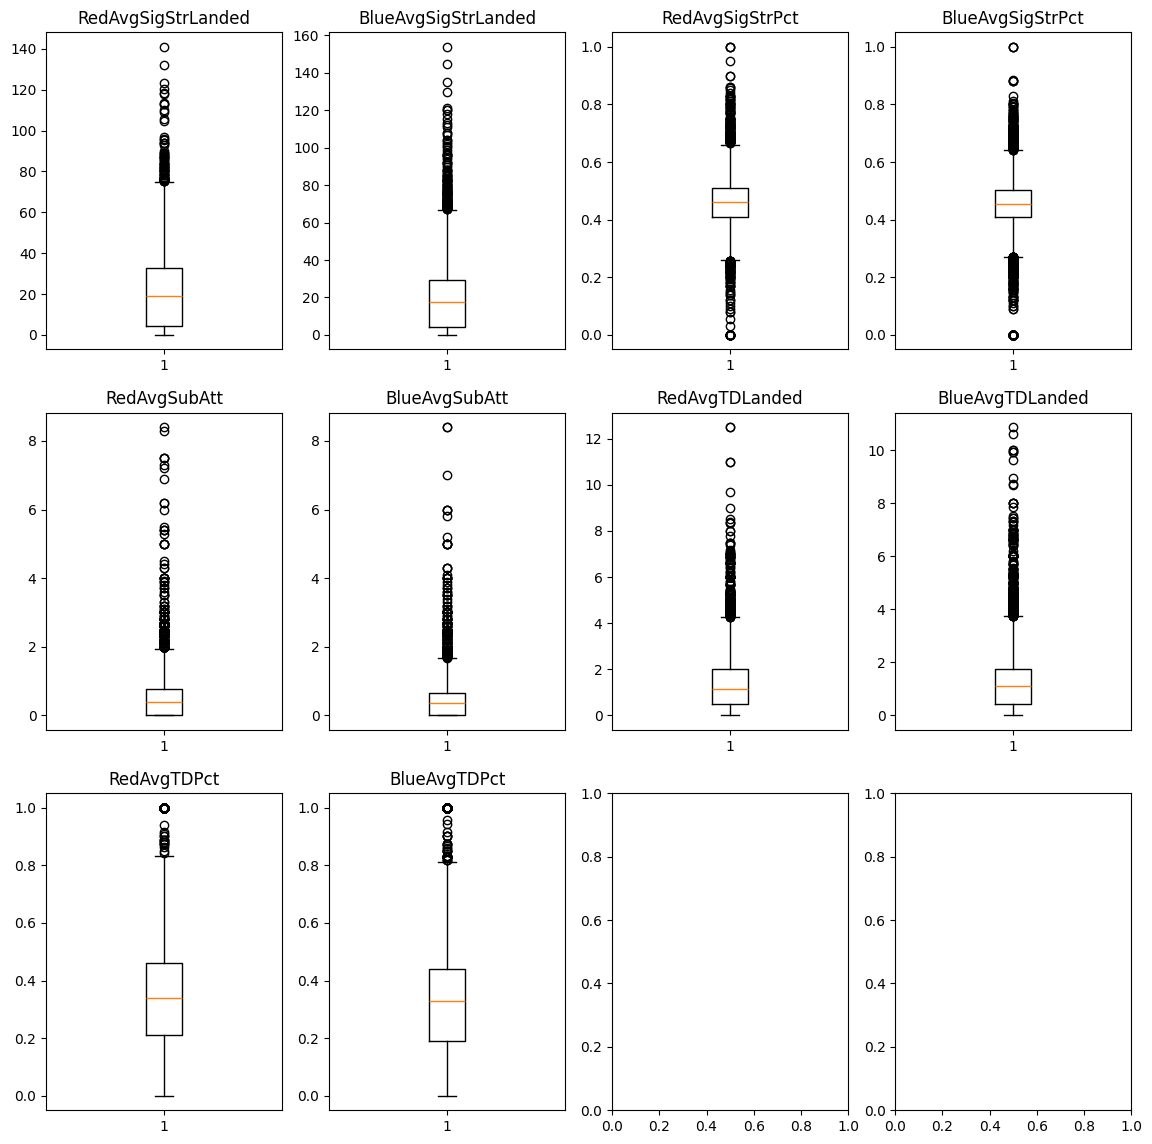

In [18]:
stats_columns = ['RedAvgSigStrLanded',
                'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]             
                  
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 14))
for i in range(len(stats_columns)):
    axs[int(i // 4), i % 4].boxplot(data[stats_columns[i]])
    axs[int(i // 4), i % 4].set_title(stats_columns[i])

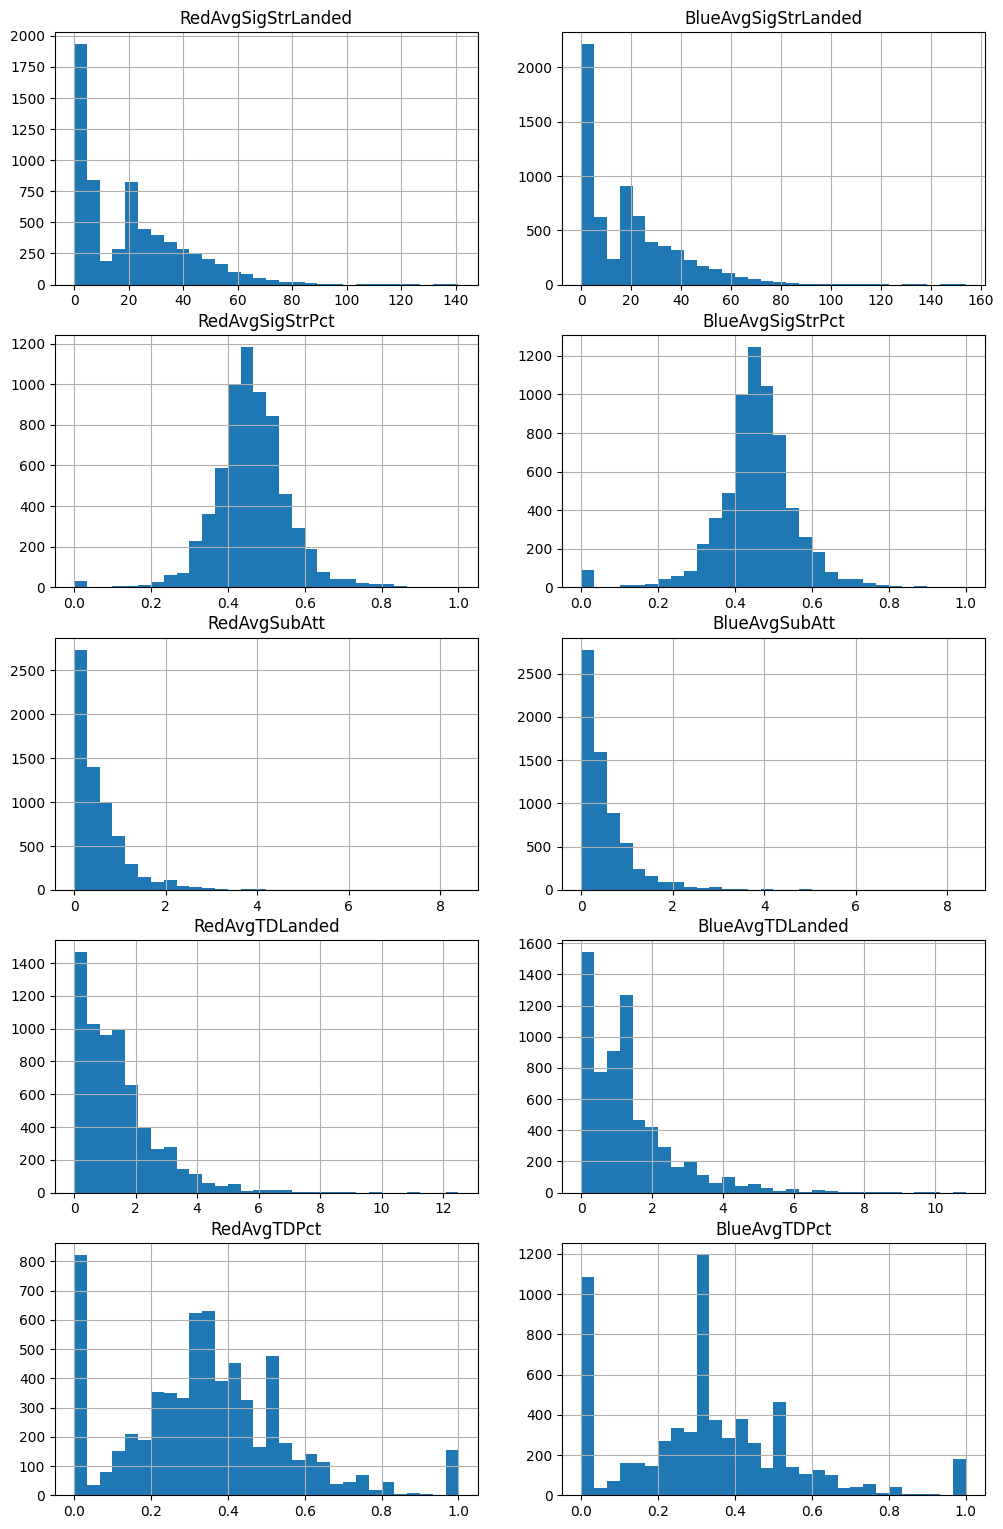

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
for i in range(len(stats_columns)):
    axs[int(i // 2), i % 2].hist(data[stats_columns[i]], bins=30)
    axs[int(i // 2), i % 2].set_title(stats_columns[i])
    axs[int(i // 2), i % 2].grid()

Посмотрим на признаки более пристально. Похоже что они содержат аномальные значения

In [20]:
data[stats_columns].describe()

,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,RedAvgSubAtt,BlueAvgSubAtt,RedAvgTDLanded,BlueAvgTDLanded,RedAvgTDPct,BlueAvgTDPct
count,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000
mean,21.163432,19.855928,0.460205,0.452981,0.537523,0.499980,1.400722,1.320765,0.341521,0.325271
std,19.182438,18.822988,0.095679,0.104272,0.674123,0.629118,1.272464,1.267825,0.214729,0.223308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.320000,4.220000,0.410000,0.410000,0.000000,0.000000,0.500000,0.420000,0.210000,0.190000
50%,19.000000,17.713136,0.460000,0.453011,0.400000,0.375000,1.150000,1.120000,0.340000,0.329552
75%,32.606250,29.333300,0.510000,0.503000,0.777800,0.666700,2.000000,1.750000,0.460000,0.441250
max,141.000000,154.000000,1.000000,1.000000,8.400000,8.400000,12.500000,10.860000,1.000000,1.000000


Возьмем одного бойца и посмотрим признаки, описывающие его статистики

In [21]:
data[data['BlueFighter'] == 'Yan Xiaonan'][['BlueFighter'] + stats_columns[1::2]]

,BlueFighter,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct
341,Yan Xiaonan,4.970000,0.440000,0.000000,1.000000,0.730000
827,Yan Xiaonan,4.970000,0.440000,0.000000,1.000000,0.730000
1112,Yan Xiaonan,4.970000,0.440000,0.000000,1.000000,0.730000
1432,Yan Xiaonan,4.970000,0.440000,0.000000,1.000000,0.730000
2067,Yan Xiaonan,6.720000,0.420000,0.000000,1.200000,0.750000
2397,Yan Xiaonan,6.850000,0.400000,0.000000,0.250000,0.250000
3230,Yan Xiaonan,96.000000,0.450000,0.000000,0.000000,0.000000
3494,Yan Xiaonan,17.797391,0.443653,0.568189,1.370605,0.362627


In [22]:
data.groupby(by='RedFighter')[stats_columns[0::2]].median().reset_index()

,RedFighter,RedAvgSigStrLanded,RedAvgSigStrPct,RedAvgSubAtt,RedAvgTDLanded,RedAvgTDPct
0,Jun Yong Park,19.501712,0.522,0.0,0.50,0.25
1,AJ Dobson,4.290000,0.460,0.3,1.67,0.75
2,AJ Fletcher,3.360000,0.490,0.9,1.54,0.35
3,Aalon Cruz,9.040000,0.400,0.0,0.00,0.00
4,Aaron Phillips,9.755000,0.490,0.8,0.43,0.25
...,...,...,...,...,...,...
1656,Zhang Lipeng,14.500000,0.435,1.5,3.00,0.40
1657,Zhang Mingyang,8.900000,0.560,0.0,0.00,0.00
1658,Zhang Weili,5.660000,0.530,0.5,2.51,0.46
1659,Zubaira Tukhugov,35.000000,0.390,0.0,2.13,0.39


In [23]:
data[data['RedFighter'] == 'Zubaira Tukhugov'][['RedFighter'] + stats_columns[0::2]]

,RedFighter,RedAvgSigStrLanded,RedAvgSigStrPct,RedAvgSubAtt,RedAvgTDLanded,RedAvgTDPct
967,Zubaira Tukhugov,3.17,0.390,0.0,2.13,0.39
4399,Zubaira Tukhugov,37.50,0.475,0.0,1.50,0.25
4941,Zubaira Tukhugov,35.00,0.360,0.0,3.00,0.50


Видно, что многие данные (особенно данные о более давнишних боях) содержат аномальные значения. Поскольку данные упорядочены во времени, можно попробовать определить границу, после которой начинают появляться аномальные значения

In [24]:
df_replace_outbursts = data.iloc[:1500, :].groupby(by='WeightClass')[stats_columns].mean().reset_index()
df_replace_outbursts

,WeightClass,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,RedAvgSubAtt,BlueAvgSubAtt,RedAvgTDLanded,BlueAvgTDLanded,RedAvgTDPct,BlueAvgTDPct
0,0,4.118414,3.970485,0.455858,0.461456,0.716505,0.539482,1.647767,1.451068,0.372265,0.367767
1,1,4.028142,4.116150,0.468407,0.463982,0.488496,0.418142,1.565354,1.584027,0.350619,0.345619
2,2,4.220483,4.037198,0.474106,0.472077,0.675362,0.746377,1.623913,1.639517,0.385990,0.351787
3,3,4.304726,4.306119,0.468408,0.468159,0.606468,0.430846,1.735622,1.685124,0.376020,0.336567
4,4,4.282473,4.256154,0.479835,0.478956,0.500000,0.376923,1.443516,1.299725,0.400110,0.348901
5,5,4.039943,4.033580,0.504830,0.494205,0.761932,0.561932,1.727898,1.668068,0.382784,0.399773
6,6,4.375510,4.055612,0.507857,0.485612,0.450000,0.287755,1.241429,1.061020,0.396633,0.346735
7,7,3.978515,4.430099,0.496238,0.506139,0.300990,0.360396,1.378317,1.358020,0.328812,0.351683


In [25]:
df_replace_outbursts = data.iloc[:2500, :].groupby(by='WeightClass')[stats_columns].mean().reset_index()
df_replace_outbursts

,WeightClass,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,RedAvgSubAtt,BlueAvgSubAtt,RedAvgTDLanded,BlueAvgTDLanded,RedAvgTDPct,BlueAvgTDPct
0,0,4.400371,4.188011,0.451581,0.444392,0.686318,0.540946,1.613139,1.403199,0.382977,0.371243
1,1,4.744893,4.565828,0.457460,0.443997,0.488856,0.449574,1.503218,1.579362,0.355449,0.336098
2,2,4.777827,4.468539,0.467955,0.454357,0.726039,0.704382,1.622022,1.515225,0.382491,0.356037
3,3,4.656324,4.420844,0.465458,0.455110,0.629561,0.430031,1.687273,1.578840,0.378001,0.321807
4,4,4.743584,4.572854,0.469692,0.448967,0.517815,0.433179,1.421060,1.288808,0.407023,0.355943
5,5,4.298997,4.194702,0.495433,0.482848,0.703529,0.583737,1.726540,1.612768,0.390502,0.364118
6,6,4.786361,4.475176,0.499075,0.480462,0.463295,0.348439,1.186474,1.135665,0.364527,0.330769
7,7,4.398641,4.603966,0.483676,0.486665,0.426117,0.361968,1.318777,1.140802,0.318878,0.334935


Примерно после 2500 тысяч строчек в данных начинается полный хаос, ликвидировать который нет никакой возможности. Поэтому оставим только первые 2500 тысячи строк. Пожертвуем данными ради качества.

### Работа с уменьшенной выборкой

In [227]:
data_reduced = data_main.iloc[:2000, :]
# data_reduced = data_main

Таким образом видим, что оставшиеся данные охватывают период за последние 5 лет

In [228]:
# Уменьшаем количество используемых признаков
data = data_reduced[valuable_features]
# data = data_reduced

# Создаем новый столбец с целевой переменной
data.loc[:, 'Result'] = data.apply(def_target, axis=1)
# Обединяем 
data.loc[:, 'RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data.loc[:, 'RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']

data.loc[:, 'BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data.loc[:, 'BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим лишние признаки
data = data.drop(columns=columns_to_drop, axis=1)

In [229]:
# data['Result'].value_counts(normalize=True)

In [230]:
# Преобразуем бинарные и ординальные признаки в числовой вид
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 0, 'MALE': 1})
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 1, 5: 0})
data['RedStance'] = data['RedStance'].map({'Southpaw': 0, 'Orthodox': 1})
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 0, 'Orthodox': 1})

ordinal_features = ['WeightClass', 'Result']
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

data['Result'] = data['Result'].map({'Red-Decision': 0,
                                     'Blue-Decision': 1, 
                                     'Red-KO/TKO': 2,
                                     'Blue-KO/TKO': 3,
                                     'Red-Submission': 4,                                     
                                     'Blue-Submission' : 5                                                                         
                                    })

In [231]:
for col in data.columns:
    isna_sum = 0
    if data[col].isna().any():
        isna_sum = data[col].isna().sum()
        print(f'{col}: {isna_sum}')

RedStance: 216
BlueStance: 204


In [232]:
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

colmns_with_nans = ['RedAvgSigStrLanded',                    
                    'RedAvgTDPct',
                    'BlueAvgSigStrLanded',
                    'BlueAvgTDLanded',
                    'BlueAvgTDPct'
                    ]

df_fillna_vals = data.groupby(by='WeightClass')[colmns_with_nans].mean().reset_index()
for col in colmns_with_nans:
    for i in range(8):
        data.loc[(data['WeightClass'] == i) & (data[col].isna()), col] = df_fillna_vals.loc[i, col]

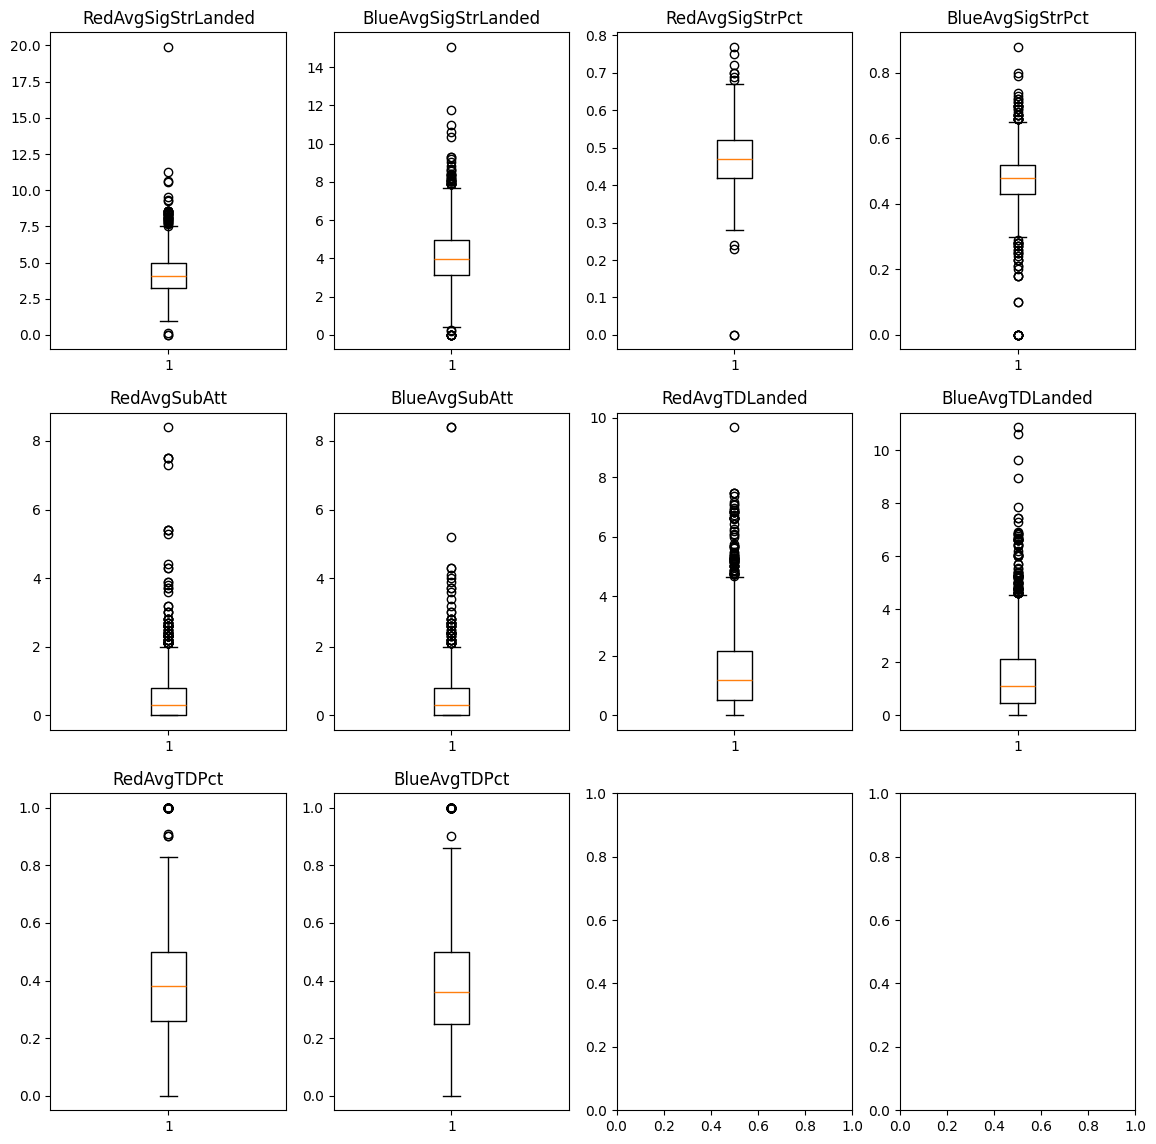

In [233]:
ig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 14))
for i in range(len(stats_columns)):
    axs[int(i // 4), i % 4].boxplot(data[stats_columns[i]])
    axs[int(i // 4), i % 4].set_title(stats_columns[i])

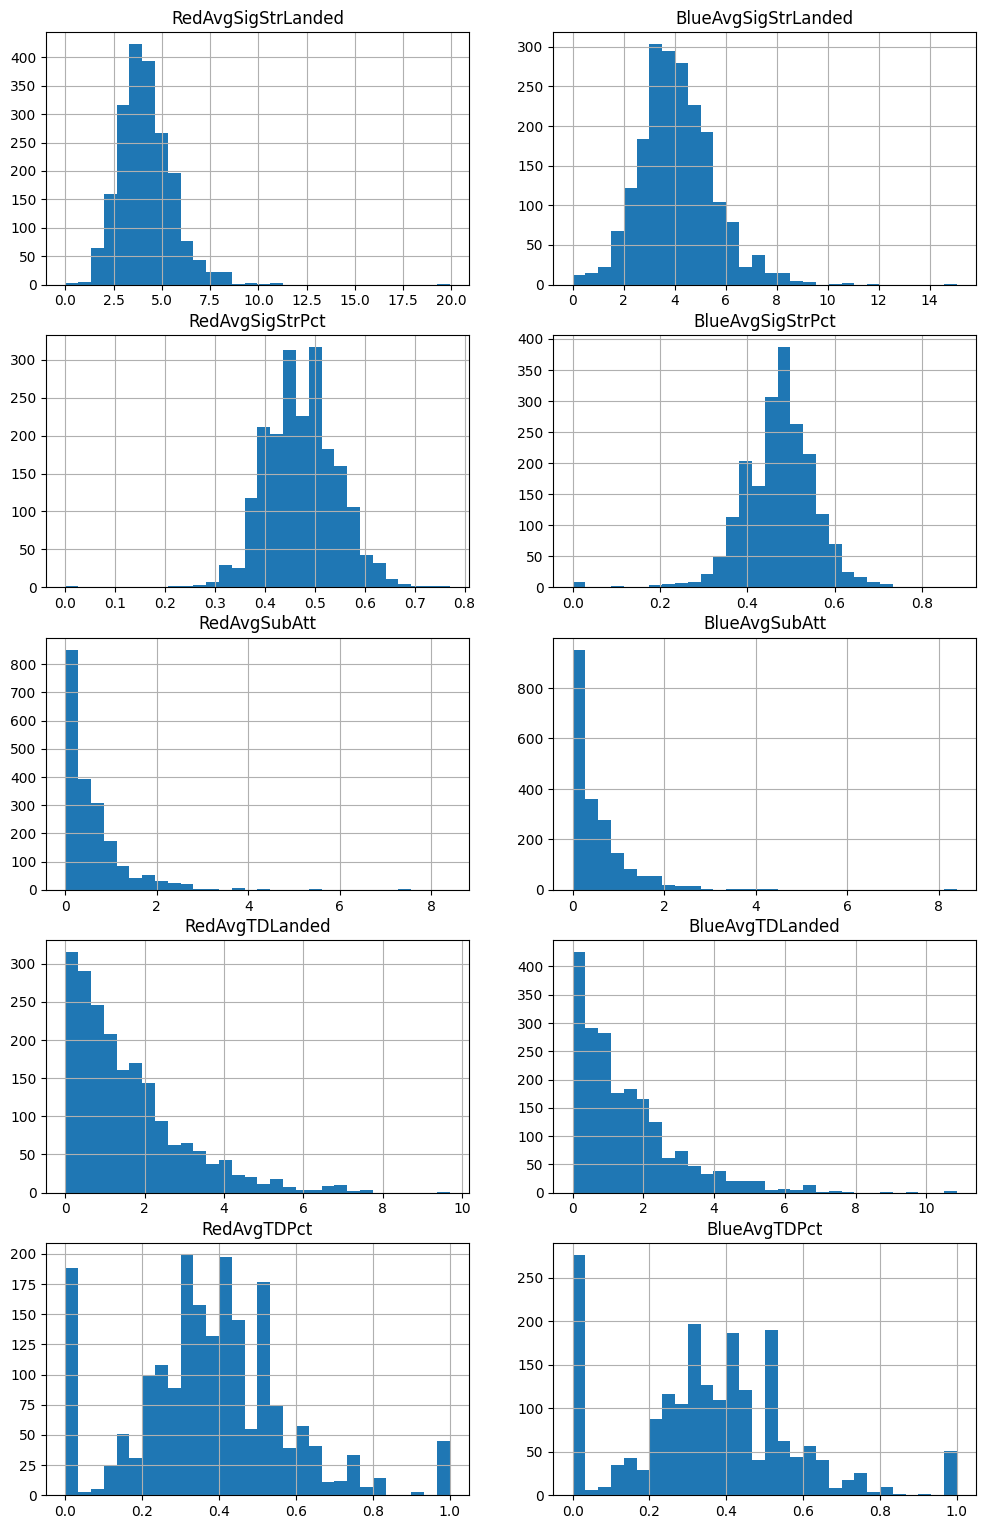

In [234]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
for i in range(len(stats_columns)):
    axs[int(i // 2), i % 2].hist(data[stats_columns[i]], bins=30)
    axs[int(i // 2), i % 2].set_title(stats_columns[i])
    axs[int(i // 2), i % 2].grid()

Теперь посмотрим на наличие корреляций

<Axes: >

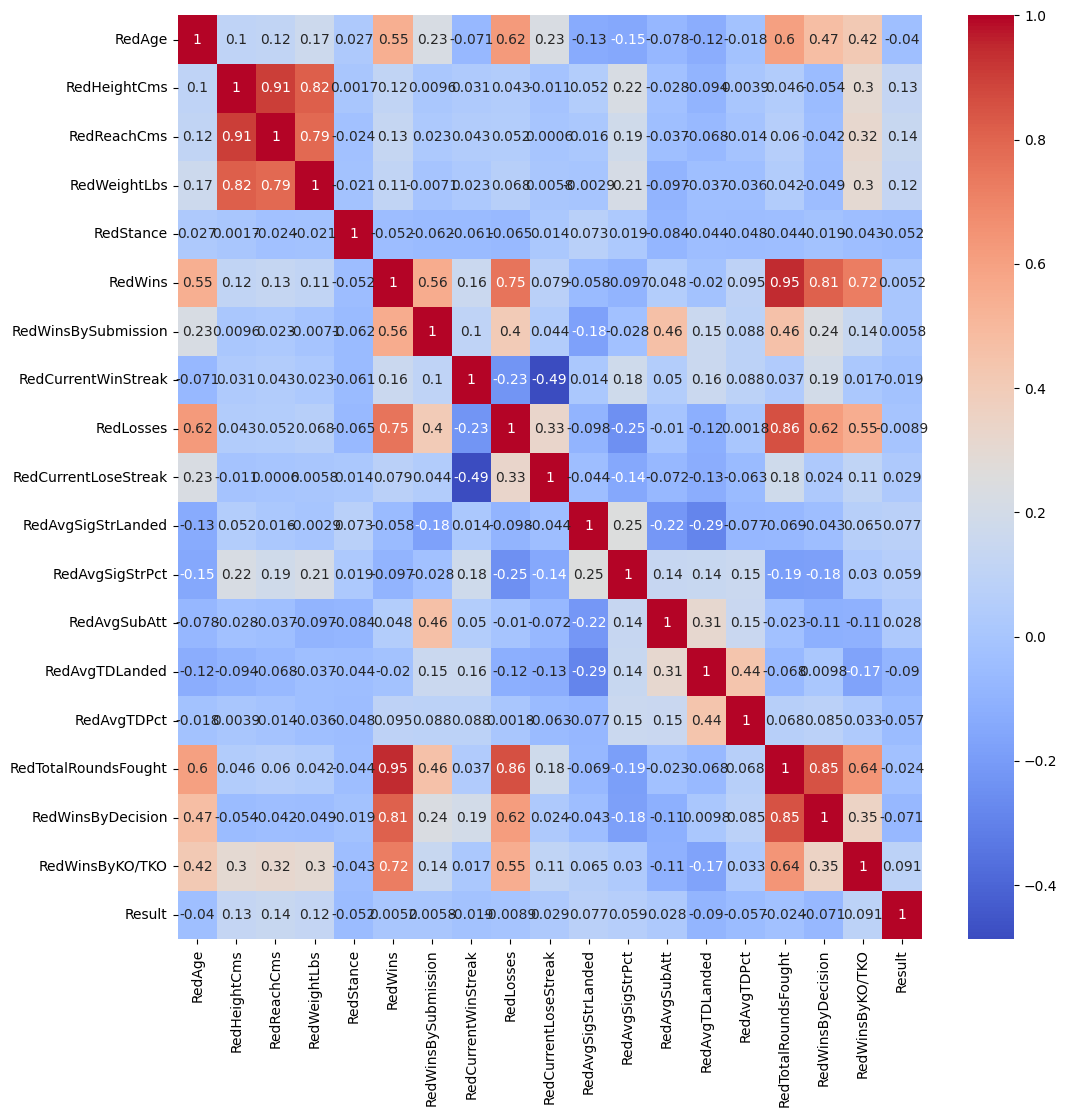

In [235]:
red_fighter_features = [col for col in data.columns if 'Red' in col]
# Добавим к рассмотрению целевую переменную
red_fighter_features.append('Result')
# Выберем из датасета только те бои, где победил красный боец
data_red = data[data['Result'].isin([0, 1, 2])]

corr_matrix = data_red[red_fighter_features[1:]].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [236]:
data.describe()

,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.790000,0.822000,0.901000,31.24500,177.144680,181.866540,159.284500,0.819000,5.611500,1.121000,...,0.471450,0.501650,1.494885,0.355695,14.999500,1.784500,2.527000,1.921000,1.788500,1.346500
std,2.204162,0.382608,0.298737,4.23662,9.531425,11.733994,35.381513,0.385114,5.017086,1.886833,...,0.082166,0.677888,1.432261,0.217892,15.494339,1.594783,2.704982,2.395961,2.204359,1.799738
min,0.000000,0.000000,0.000000,18.00000,152.400000,147.320000,115.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,28.00000,170.180000,172.720000,135.000000,1.000000,2.000000,0.000000,...,0.430000,0.000000,0.480000,0.250000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,1.000000,31.00000,177.800000,182.880000,155.000000,1.000000,4.000000,0.000000,...,0.480000,0.300000,1.090000,0.360000,10.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,5.000000,1.000000,1.000000,34.00000,185.420000,190.500000,185.000000,1.000000,8.000000,2.000000,...,0.520000,0.800000,2.110000,0.500000,21.000000,3.000000,4.000000,3.000000,3.000000,2.000000
max,7.000000,1.000000,1.000000,45.00000,200.660000,213.360000,265.000000,1.000000,33.000000,16.000000,...,0.880000,8.400000,10.860000,1.000000,111.000000,5.000000,14.000000,21.000000,13.000000,14.000000


Посмотрим на распределение классов целевой переменной

In [237]:
data['Result'].value_counts(normalize='True')

Result
0    0.2865
1    0.2155
2    0.1775
3    0.1425
4    0.1035
5    0.0745
Name: proportion, dtype: float64

### Преобразование данных для обучения модели

In [238]:
features_quntiles = {}

In [239]:
def remove_rows_with_outliers(df, columns=None):
    
    # Если columns=None, выбрать все числовые столбцы
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Создать маску для строк без аномалий
    # mask = ~df[columns].apply(lambda x: np.abs(x - x.mean()) > (2 * x.std()), axis=0).any(axis=1)
    
    # Альтернативный способ с использованием IQR
    mask = ~df[columns].apply(lambda x: (x < (x.quantile(0.25) - 3.5 * (x.quantile(0.75) - x.quantile(0.25)))) | 
                                (x > (x.quantile(0.75) + 3.5 * (x.quantile(0.75) - x.quantile(0.25))))).any(axis=1)

    # Возвращаем датафрейм с удаленными строками, содержащими аномалии
    return mask

In [269]:
def replace_outliers_with_nearest_quantile(df, columns ,is_test=False): 
    if not is_test:
        global features_quntiles
           
        for column_name in columns:            
            # Рассчитать первый и третий квартили
            q1 = df[column_name].quantile(0.25)
            q3 = df[column_name].quantile(0.75)
            
            # Рассчитать межквантильный диапазон (IQR)
            iqr = q3 - q1
            
            # Определить нижнюю и верхнюю границы для аномалий
            lower_bound = q1 - 5 * iqr
            upper_bound = q3 + 5 * iqr

            features_quntiles[column_name] = [q1, q3, lower_bound, upper_bound]
            
            # Заменить аномальные значения на ближайший квантиль
            df.loc[df[column_name] < lower_bound, column_name] = q1
            df.loc[df[column_name] > upper_bound, column_name] = q3

    else:
        for column_name in columns: 
            df.loc[df[column_name] < features_quntiles[column_name][2], column_name] = features_quntiles[column_name][0]
            df.loc[df[column_name] > features_quntiles[column_name][3], column_name] = features_quntiles[column_name][1]

    
    return df

In [241]:
X = data.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1)
y = data['Result']


test_size = int(len(X)*0.15)
X_train = X.iloc[test_size:, :]
X_train = replace_outliers_with_nearest_quantile(X_train, stats_columns)
# mask= remove_rows_with_outliers(X_train, stats_columns)
# X_train = X_train[mask]
y_train = y.iloc[test_size:]
# y_train = y_train[mask]
X_test = X.iloc[:test_size, :]
X_test = replace_outliers_with_nearest_quantile(X_test, stats_columns, is_test=True)
y_test = y.iloc[:test_size]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        92
           1       0.45      0.40      0.42        80
           2       0.40      0.45      0.43        44
           3       0.14      0.09      0.11        32
           4       0.35      0.28      0.31        29
           5       0.31      0.17      0.22        23

    accuracy                           0.40       300
   macro avg       0.35      0.33      0.33       300
weighted avg       0.39      0.40      0.39       300

Confusion Matrix:


Text(0.5, 23.52222222222222, 'predicted value')

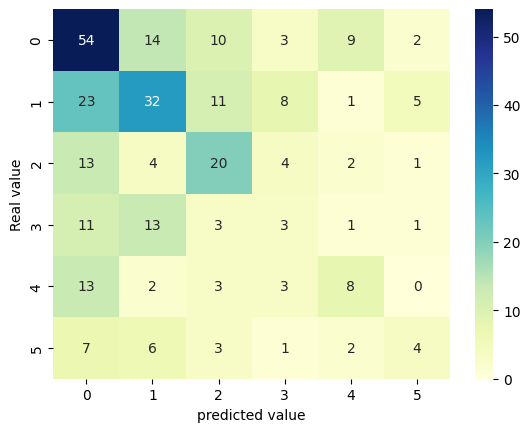

In [242]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', MinMaxScaler()),
                     ('classifier', LogisticRegression(multi_class='multinomial', random_state=8))
                     ])

# Обучаем pipeline на тренировочных данных
pipeline.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = pipeline.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Упростим задачу. Бинарная классификация

In [243]:
from copy import deepcopy

data_binary = deepcopy(data)
data_binary['Result'] = data['Result'].isin([1, 3, 5]).astype(int)
# data_binary.to_csv('ufc-master-for-binary-classification.csv')
data_binary

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,Alexandre Pantoja,Kai Asakura,0,1,0,34,165.10,170.18,125,1.0,...,0.00,0.0,0.00,0.00,0,0,6,2,0,0
1,Shavkat Rakhmonov,Ian Machado Garry,4,1,1,30,185.42,195.58,170,1.0,...,0.55,0.3,0.77,0.55,20,0,0,1,5,3
2,Ciryl Gane,Alexander Volkov,7,1,1,34,193.04,205.74,245,1.0,...,0.57,0.2,0.45,0.63,44,0,3,4,5,6
3,Bryce Mitchell,Kron Gracie,2,1,1,30,177.80,177.80,145,0.0,...,0.44,0.5,0.47,0.25,7,0,6,0,0,0
4,Nate Landwehr,Dooho Choi,2,1,1,36,175.26,182.88,145,1.0,...,0.53,0.8,0.75,0.37,15,1,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Carlos Condit,Matt Brown,4,1,1,36,187.96,190.50,170,1.0,...,0.54,1.5,1.60,0.47,58,0,3,6,2,11
1996,Santiago Ponzinibbio,Li Jingliang,4,1,1,34,182.88,185.42,170,1.0,...,0.42,0.0,1.32,0.39,32,1,4,5,3,6
1997,Joaquin Buckley,Alessio Di Chirico,5,1,1,26,177.80,193.04,185,0.0,...,0.40,0.0,1.66,0.45,21,1,0,2,2,1
1998,Punahele Soriano,Dusko Todorovic,5,1,1,28,180.34,182.88,185,0.0,...,0.67,0.0,0.65,0.06,5,0,1,1,1,1


In [244]:
data_binary['Result'].value_counts(normalize='True')

Result
0    0.5675
1    0.4325
Name: proportion, dtype: float64

In [245]:
X = data_binary.drop(columns=['Result', 
                              'RedFighter', 
                              'BlueFighter', 
                            #   'WeightClass', 
                              # 'RedStance', 
                              # 'BlueStance'
                              ], axis=1)
y = data_binary['Result']
X_train = X.iloc[test_size:, :]
X_train = replace_outliers_with_nearest_quantile(X_train, stats_columns)
# mask= remove_rows_with_outliers(X_train, stats_columns)

# X_train = X_train[mask]
y_train = y.iloc[test_size:]
# y_train = y_train[mask]
X_test = X.iloc[:test_size, :]
X_test = replace_outliers_with_nearest_quantile(X_test, stats_columns, is_test=True)
y_test = y.iloc[:test_size]



# X_train = X.iloc[test_size:, :]
# y_train = y.iloc[test_size:]
# X_test = X.iloc[:test_size, :]
# y_test = y.iloc[:test_size]

In [246]:
X_train

,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,...,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
300,1,1,1,32,165.10,167.64,135,1.0,4,0,...,4.58,0.57,0.6,0.60,0.22,8,3,1,1,1
301,0,0,1,35,157.48,149.86,115,1.0,4,1,...,7.45,0.52,0.0,0.20,0.14,12,3,0,2,0
302,7,1,0,39,190.50,200.66,260,1.0,18,0,...,4.05,0.49,0.6,1.23,0.37,15,4,14,3,0
303,4,1,1,30,177.80,193.04,170,0.0,8,0,...,2.50,0.43,0.0,0.77,1.00,2,2,6,0,2
304,6,1,1,36,182.88,193.04,205,1.0,10,2,...,7.41,0.59,0.3,0.95,0.75,12,2,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4,1,1,36,187.96,190.50,170,1.0,13,4,...,3.81,0.54,1.5,1.60,0.47,58,3,6,2,11
1996,4,1,1,34,182.88,185.42,170,1.0,9,0,...,4.51,0.42,0.0,1.32,0.39,32,4,5,3,6
1997,5,1,1,26,177.80,193.04,185,0.0,2,0,...,3.25,0.40,0.0,1.66,0.45,21,0,2,2,1
1998,5,1,1,28,180.34,182.88,185,0.0,2,0,...,8.04,0.67,0.0,0.65,0.06,5,1,1,1,1


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       165
           1       0.65      0.68      0.67       135

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



Text(0.5, 23.52222222222222, 'predicted value')

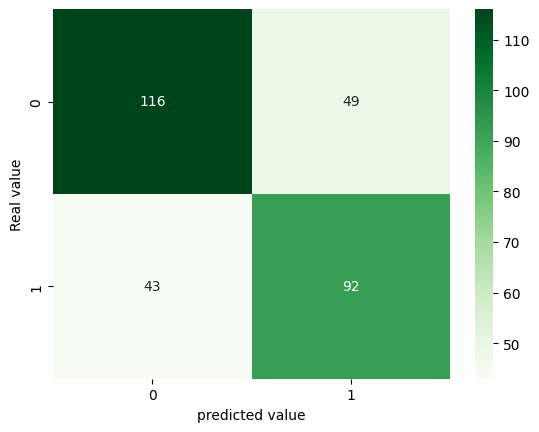

In [247]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                     ('scaler', MinMaxScaler()),
                     ('logreg', LogisticRegression(max_iter=1000))
                     ])

params = {'logreg__penalty': [None, 'l1', 'l2'],
          'logreg__C': np.linspace(0.001, 10000, 24),
          'logreg__solver': ['liblinear', 'lbfgs', 'newton-cs'],
          'logreg__class_weight': ['none', 'balanced'],
          'logreg__fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_binary = GridSearchCV(estimator=pipeline, param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [248]:
gs_binary.best_params_

{'logreg__C': np.float64(9565.21743478261),
 'logreg__class_weight': 'balanced',
 'logreg__fit_intercept': True,
 'logreg__penalty': 'l2',
 'logreg__solver': 'lbfgs'}

In [249]:
# Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data_binary['RedFighter'].iloc[:test_size],
    'BlueFighter': data_binary['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data_binary['Result'].iloc[:test_size]
})

# for i in range(len(X_test)):
#     print(f"Вероятность победы {data_binary.loc[i, 'RedFighter']}: {y_proba[i][0] * 100:.2f}% Вероятность победы {data_binary.loc[i, 'BlueFighter']}: {y_proba[i][1] * 100:.2f}%")


# # Метрики
# print("Log Loss:", log_loss(y_test, y_proba))
# print("ROC-AUC:", roc_auc_score(y_test, y_proba[:, 1]))
results_df

,RedFighter,BlueFighter,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner
0,Alexandre Pantoja,Kai Asakura,0.921006,0.078994,0
1,Shavkat Rakhmonov,Ian Machado Garry,0.379560,0.620440,0
2,Ciryl Gane,Alexander Volkov,0.560588,0.439412,0
3,Bryce Mitchell,Kron Gracie,0.837763,0.162237,0
4,Nate Landwehr,Dooho Choi,0.520051,0.479949,1
...,...,...,...,...,...
295,Victor Martinez,Tom Nolan,0.442664,0.557336,1
296,Oumar Sy,Tuco Tokkos,0.809807,0.190193,0
297,Tamires Vidal,Melissa Gatto,0.320849,0.679151,1
298,Abus Magomedov,Warlley Alves,0.402884,0.597116,0


### Разбираемся с вероятностями

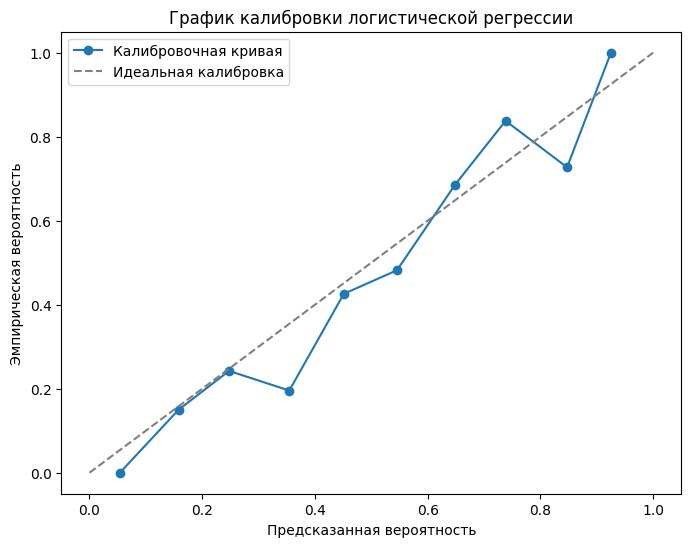

In [250]:
# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

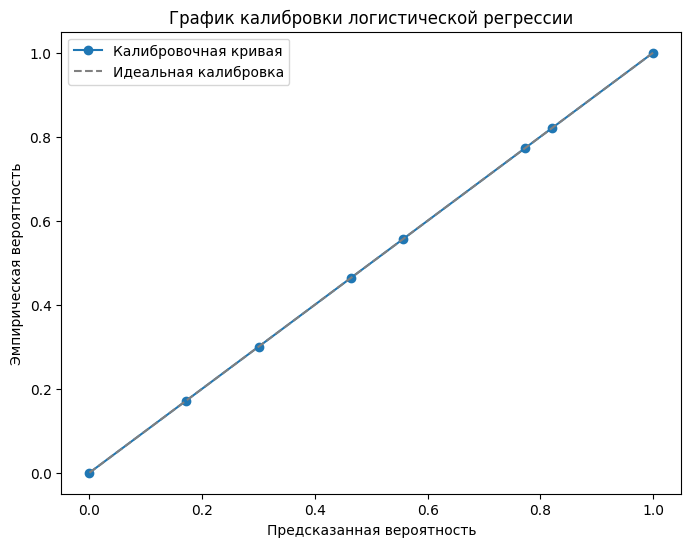

In [251]:
from sklearn.calibration import CalibratedClassifierCV

model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")
# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       165
           1       0.72      0.64      0.67       135

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300



Text(0.5, 23.52222222222222, 'predicted value')

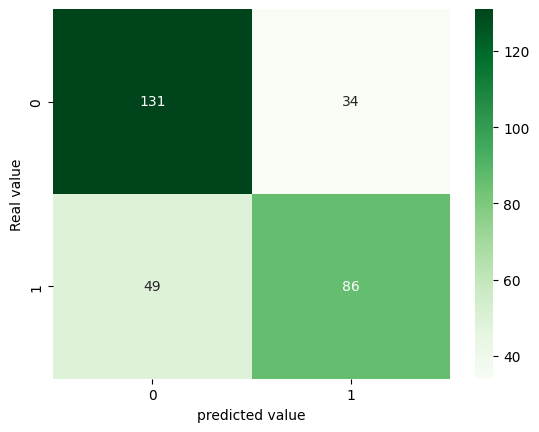

In [252]:
y_pred_calibrated = calibrated_model.predict(X_test)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [253]:
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data_binary['RedFighter'].iloc[:test_size],
    'BlueFighter': data_binary['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': calibrated_proba [:, 0],
    'ProbabilityBlueWins': calibrated_proba [:, 1],
    'ActualWinner': data_binary['Result'].iloc[:test_size]
})

# for i in range(len(X_test)):
#     print(f"Вероятность победы {data_binary.loc[i, 'RedFighter']}: {calibrated_proba[i][0] * 100:.2f}% Вероятность победы {data_binary.loc[i, 'BlueFighter']}: {calibrated_proba[i][1] * 100:.2f}%")
#     # print(f"Вероятность победы {data_binary.loc[i, 'BlueFighter']}: {y_proba[i][1] * 100:.2f}%")

# # Метрики
# print("Log Loss:", log_loss(y_test, calibrated_proba))
# print("ROC-AUC:", roc_auc_score(y_test, calibrated_proba[:, 1]))
results_df.iloc[0:30, :]

,RedFighter,BlueFighter,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner
0,Alexandre Pantoja,Kai Asakura,1.000000,0.000000,0
1,Shavkat Rakhmonov,Ian Machado Garry,0.437500,0.562500,0
2,Ciryl Gane,Alexander Volkov,0.700000,0.300000,0
3,Bryce Mitchell,Kron Gracie,0.833333,0.166667,0
4,Nate Landwehr,Dooho Choi,0.535714,0.464286,1
5,Dominick Reyes,Anthony Smith,0.828571,0.171429,0
6,Vicente Luque,Themba Gorimbo,0.186047,0.813953,0
7,Movsar Evloev,Aljamain Sterling,0.535714,0.464286,0
8,Randy Brown,Bryan Battle,0.437500,0.562500,1
9,Chris Weidman,Eryk Anders,0.828571,0.171429,1


In [254]:
# Извлекаем scaler из пайплайна
scaler = pipeline.named_steps['scaler']

# Применяем scaler к данным
processed_data = scaler.fit_transform(X_train)
scaled_df = pd.DataFrame(processed_data, columns=X_train.columns)
# Выводим обработанные данные
scaled_df

,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,...,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,0.142857,1.0,1.0,0.538462,0.263158,0.307692,0.133333,1.0,0.121212,0.0000,...,0.388795,0.602564,0.176471,0.076531,0.22,0.074074,0.214286,0.047619,0.076923,0.071429
1,0.000000,0.0,1.0,0.653846,0.105263,0.038462,0.000000,1.0,0.121212,0.0625,...,0.632428,0.538462,0.000000,0.025510,0.14,0.111111,0.214286,0.000000,0.153846,0.000000
2,1.000000,1.0,0.0,0.807692,0.789474,0.807692,0.966667,1.0,0.545455,0.0000,...,0.343803,0.500000,0.176471,0.156888,0.37,0.138889,0.285714,0.666667,0.230769,0.000000
3,0.571429,1.0,1.0,0.461538,0.526316,0.692308,0.366667,0.0,0.242424,0.0000,...,0.212224,0.423077,0.000000,0.098214,1.00,0.018519,0.142857,0.285714,0.000000,0.142857
4,0.857143,1.0,1.0,0.692308,0.631579,0.692308,0.600000,1.0,0.303030,0.1250,...,0.629032,0.628205,0.088235,0.121173,0.75,0.111111,0.142857,0.285714,0.076923,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,0.571429,1.0,1.0,0.692308,0.736842,0.653846,0.366667,1.0,0.393939,0.2500,...,0.323430,0.564103,0.441176,0.204082,0.47,0.537037,0.214286,0.285714,0.153846,0.785714
1696,0.571429,1.0,1.0,0.615385,0.631579,0.576923,0.366667,1.0,0.272727,0.0000,...,0.382852,0.410256,0.000000,0.168367,0.39,0.296296,0.285714,0.238095,0.230769,0.428571
1697,0.714286,1.0,1.0,0.307692,0.526316,0.692308,0.466667,0.0,0.060606,0.0000,...,0.275891,0.384615,0.000000,0.211735,0.45,0.194444,0.000000,0.095238,0.153846,0.071429
1698,0.714286,1.0,1.0,0.384615,0.578947,0.538462,0.466667,0.0,0.060606,0.0000,...,0.682513,0.730769,0.000000,0.082908,0.06,0.046296,0.071429,0.047619,0.076923,0.071429


In [255]:
print(X.columns)

Index(['WeightClass', 'Gender', 'NumberOfRounds', 'RedAge', 'RedHeightCms',
       'RedReachCms', 'RedWeightLbs', 'RedStance', 'RedWins',
       'RedWinsBySubmission', 'RedCurrentWinStreak', 'RedLosses',
       'RedCurrentLoseStreak', 'RedAvgSigStrLanded', 'RedAvgSigStrPct',
       'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct', 'RedTotalRoundsFought',
       'BlueAge', 'BlueHeightCms', 'BlueReachCms', 'BlueWeightLbs',
       'BlueStance', 'BlueWins', 'BlueWinsBySubmission',
       'BlueCurrentWinStreak', 'BlueLosses', 'BlueCurrentLoseStreak',
       'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 'BlueAvgSubAtt',
       'BlueAvgTDLanded', 'BlueAvgTDPct', 'BlueTotalRoundsFought',
       'RedWinsByDecision', 'RedWinsByKO/TKO', 'BlueWinsByDecision',
       'BlueWinsByKO/TKO'],
      dtype='object')


### Создание новых признаков

In [256]:
X_featured = deepcopy(X)

In [257]:
# Создаем новые признаки
def create_new_features(df):    
    df['Age_diff'] = df['RedAge'] - df['BlueAge']
    df['Height_diff'] = df['RedHeightCms'] - df['BlueHeightCms']
    df['Reach_diff'] = df['RedReachCms'] - df['BlueReachCms']
    df['Weight_diff'] = df['RedWeightLbs'] - df['BlueWeightLbs']
    df['Red_wins_loss_diff'] = df['RedWins'] - df['RedLosses']
    df['Blue_wins_loss_diff'] = df['BlueWins'] - df['BlueLosses']
    df['Red_Blue_Wins_diff'] = df['RedWins'] - df['BlueWins']
    df['Red_Blue_Loss_diff'] = df['RedLosses'] - df['BlueLosses']
    # Находим разницу между числом побед-поражений для обоих бойцов
    df['Red_Blue_wins_loss_diff'] = df['Red_wins_loss_diff'] - df['Blue_wins_loss_diff']
    return df

# Находим разницу в текущих сериях побед/поражений для двух бойцов
def red_blue_streak_diff_calc(row):
    if row['RedCurrentWinStreak'] > 0: 
        if row['BlueCurrentWinStreak'] > 0:
            return row['RedCurrentWinStreak'] - row['BlueCurrentWinStreak']
        else:
            return row['RedCurrentWinStreak'] + row['BlueCurrentLoseStreak']
    else:
        if row['BlueCurrentWinStreak'] > 0:
            return -row['RedCurrentLoseStreak'] - row['BlueCurrentWinStreak']
        else:
            return -row['RedCurrentLoseStreak'] + row['BlueCurrentLoseStreak']
      
# Создаем новые признаки, касающиеся статистики бойцов
def create_new_stats_features(df):
    df['RedSignStrikesAverage'] = df['RedAvgSigStrLanded'] * df['RedAvgSigStrPct']
    df['BlueSignStrikesAverage'] = df['BlueAvgSigStrLanded'] * df['BlueAvgSigStrPct']

    df['RedSuccesfullTDAverage'] = df['RedAvgTDLanded'] * df['RedAvgTDPct']
    df['BlueSuccesfullTDAverage'] = df['BlueAvgTDLanded'] * df['BlueAvgTDPct']

    # Найдем разницу между статистическими показателями бойцов
    df['Red_Blue_SignStrikAvg_diff'] = df['RedSignStrikesAverage'] - df['BlueSignStrikesAverage'] 
    df['Red_Blue_SuccTDAvg_diff'] = df['RedSuccesfullTDAverage'] - df['BlueSuccesfullTDAverage'] 
    df['Red_Blue_AvgSubAtt_diff'] = df['RedAvgSubAtt'] - df['BlueAvgSubAtt']
    return df

Добавим вторую степень некоторых признаков

In [258]:
# X_featured['Red_Blue_SignStrikAvg_diff_2'] = np.pow(X_featured['Red_Blue_SignStrikAvg_diff'], 2)
# X_featured['Red_Blue_SuccTDAvg_diff_2'] = np.pow(X_featured['Red_Blue_SuccTDAvg_diff'], 2)
# X_featured['Red_Blue_AvgSubAtt_diff_2'] = np.pow(X_featured['Red_Blue_AvgSubAtt_diff'], 2)

In [259]:
# Убираем исходные признаки и оставляем только созданные
def drop_features(df):
    df = df.drop(columns=[
                          'RedAge',
                          'RedHeightCms',
                          'RedReachCms',
                          'RedWeightLbs',
                          'BlueAge',
                          'BlueHeightCms',
                          'BlueReachCms',
                          'BlueWeightLbs',
                          'RedWins',
                          'RedLosses',
                          'BlueWins',
                          'BlueLosses',
                          'RedCurrentWinStreak',
                          'RedCurrentLoseStreak',
                          'RedTotalRoundsFought',
                          'BlueCurrentWinStreak',
                          'BlueCurrentLoseStreak',
                        #   'Red_wins_loss_diff',
                        #   'Blue_wins_loss_diff',                                     
                        #   'WeightClass',
                          'RedAvgSigStrLanded',
                          'RedAvgSigStrPct',
                          'BlueAvgSigStrLanded',
                          'BlueAvgSigStrPct',
                          'RedAvgTDLanded',
                          'RedAvgTDPct', 
                          'BlueAvgTDLanded',
                          'BlueAvgTDPct',
                          'RedAvgSubAtt',
                          'RedSignStrikesAverage',
                          'BlueSignStrikesAverage',
                          'RedSuccesfullTDAverage',
                          'BlueSuccesfullTDAverage',
                          'BlueAvgSubAtt',
                          'Gender',
                          'NumberOfRounds',
                          'RedWinsBySubmission',
                          'BlueWinsBySubmission',
                          'RedWinsByDecision',
                          'RedWinsByKO/TKO',
                          'BlueWinsByDecision',
                          'BlueWinsByKO/TKO',
                          'BlueTotalRoundsFought'                                    
                          ], axis=1)
    return df

In [260]:
# X_featured.to_csv('ufc-master-for-binary-classification_featured.csv')

In [261]:
# X = replace_outliers_with_nearest_quantile(X, stats_columns)
X_train = X.iloc[test_size:, :]
X_train = replace_outliers_with_nearest_quantile(X_train, stats_columns)
# mask= remove_rows_with_outliers(X_train, stats_columns)
# X_train = X_train[mask]
y_train = y.iloc[test_size:]
# y_train = y_train[mask]
X_test = X.iloc[:test_size]
X_test = replace_outliers_with_nearest_quantile(X_test, stats_columns, is_test=True)
y_test = y.iloc[:test_size]

X_train = create_new_features(X_train)
X_train = create_new_stats_features(X_train)
X_train['Red_Blue_curr_streak_diff'] = X_train.apply(red_blue_streak_diff_calc, axis=1)
X_train = drop_features(X_train)

X_test = create_new_features(X_test)
X_test = create_new_stats_features(X_test)
X_test['Red_Blue_curr_streak_diff'] = X_test.apply(red_blue_streak_diff_calc, axis=1)
X_test = drop_features(X_test)

X_train

,WeightClass,RedStance,BlueStance,Age_diff,Height_diff,Reach_diff,Weight_diff,Red_wins_loss_diff,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,Red_Blue_SignStrikAvg_diff,Red_Blue_SuccTDAvg_diff,Red_Blue_AvgSubAtt_diff,Red_Blue_curr_streak_diff
300,1,1.0,1.0,4,0.00,-2.54,0,2,0,2,0,2,-1.7658,0.7635,-0.6,0.0
301,0,1.0,1.0,5,0.00,-10.16,0,1,0,2,1,1,-2.2873,0.0171,0.5,0.0
302,7,1.0,1.0,8,2.54,-2.54,14,8,4,13,9,4,-0.7445,-0.3069,-0.6,-4.0
303,4,0.0,1.0,0,-17.78,0.00,0,4,2,6,4,2,0.4118,0.1316,0.0,1.0
304,6,1.0,1.0,3,-10.16,-2.54,0,7,5,4,2,2,-2.3361,-0.5046,-0.1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4,1.0,1.0,-4,5.08,0.00,0,3,4,-2,-1,-1,-0.6183,-0.4495,-0.4,2.0
1996,4,1.0,1.0,2,0.00,5.08,0,7,5,0,-2,2,-0.2289,-0.2772,0.0,8.0
1997,5,0.0,1.0,-5,-5.08,5.08,0,1,-2,-1,-4,3,0.5582,-0.6414,0.0,5.0
1998,5,0.0,1.0,2,-5.08,-5.08,0,2,2,0,0,0,-3.7110,2.5850,0.0,0.0


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       165
           1       0.65      0.64      0.65       135

    accuracy                           0.68       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.68      0.68      0.68       300



Text(0.5, 23.52222222222222, 'predicted value')

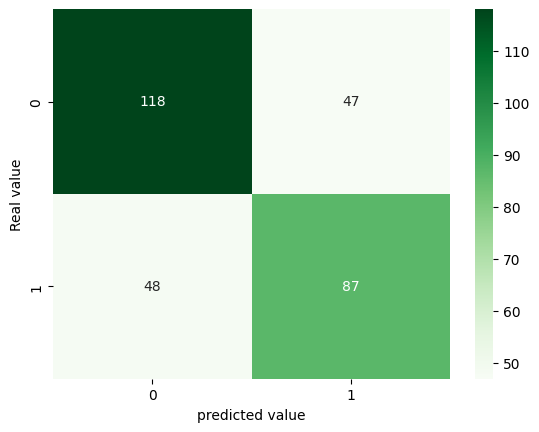

In [262]:
# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

F1-мера на тестовой выборке: 0.705415349238287
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.75       165
           1       0.72      0.59      0.64       135

    accuracy                           0.71       300
   macro avg       0.71      0.70      0.70       300
weighted avg       0.71      0.71      0.71       300



Text(0.5, 23.52222222222222, 'predicted value')

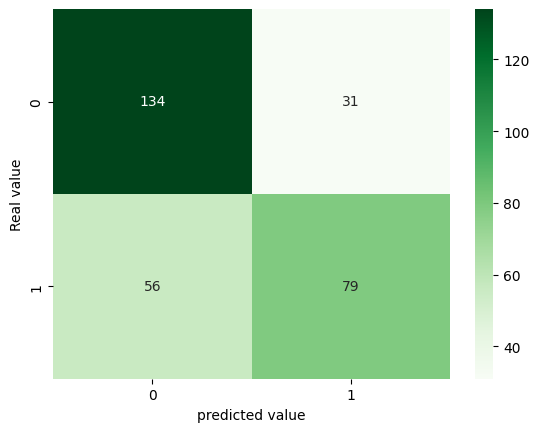

In [263]:
# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Калибруем вероятности
model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test)
# Выводим метрики качества модели
print('F1-мера на тестовой выборке:', f1_score(y_test, y_pred_calibrated, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [264]:
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)


# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data_binary['RedFighter'].iloc[:test_size],
    'BlueFighter': data_binary['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': calibrated_proba [:, 0],
    'ProbabilityBlueWins': calibrated_proba [:, 1],
    'ActualWinner': data_binary['Result'].iloc[:test_size]
})

In [265]:
results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

,RedFighter,BlueFighter,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
0,Alexandre Pantoja,Kai Asakura,0.916667,0.083333,0,0,0
1,Shavkat Rakhmonov,Ian Machado Garry,0.400000,0.600000,0,1,1
2,Ciryl Gane,Alexander Volkov,0.564516,0.435484,0,0,0
3,Bryce Mitchell,Kron Gracie,0.875000,0.125000,0,0,0
4,Nate Landwehr,Dooho Choi,0.564516,0.435484,1,0,1
5,Dominick Reyes,Anthony Smith,0.800000,0.200000,0,0,0
6,Vicente Luque,Themba Gorimbo,0.400000,0.600000,0,1,1
7,Movsar Evloev,Aljamain Sterling,0.833333,0.166667,0,0,0
8,Randy Brown,Bryan Battle,0.400000,0.600000,1,1,0
9,Chris Weidman,Eryk Anders,0.600000,0.400000,1,0,1


In [266]:
print(results_df['Prediction_Errors'].sum())

87


In [267]:
print(results_df['Prediction_Errors'].sum()/len(y_test))

0.29


In [268]:
171/500

0.342